# <span style="color:rgb(106,127,16)">Unsupervised learning </span>


<div style="text-align: right"><span style="color:rgb(106,127,16)">May 27, 2020
    </span></div>
<br>


Recall from the [previous lecture](15_SupervisedLearning.ipynb) that  *unsupervised learning* refers to machine learning models that identify structure in unlabeled data. In this activity, we study **Principal Component Analysis (PCA)** which is a commonly used technique in unsupervised learning, often used for discovering structure in high-dimensional data, and for dimensionality reduction.

In this activity, I will extensively draw upon what you studied in earlier activities: in particular, I will try to detail the connections between PCA and [SVD](10_SVD.ipynb), the differences in the jargon, and highlight the distinctions between PCA and [regression](15_SupervisedLearning.ipynb), particularly to illustrate how unsupervised machine learning is different from supervised machine learning. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
import matplotlib.cm as cmx
from sklearn.decomposition import PCA
from scipy.linalg import svd
from numpy.linalg import norm
rng = np.random.default_rng(13)

## Definitions

- Given a *one*-dimensional data vector $ x = [x_1, x_2, \ldots, x_m]^t$, its *mean*, or **sample mean** is 
$$
\bar x =\frac 1 m  \sum_{i=1}^m x_i.
$$

- Consider a *multi*-dimensional $m \times n$ data array $X$ representing 
$$
m \text{ samples/observations/rows} \quad \text{ for }\quad 
n  \text{ variables/features/columns}.
$$
The $j$th column of $X$, denoted by $X_j$, represents a number of samples of a single variable. We say that such an $X$ represents **centered data** if the sample mean of $X_j$ is zero for every column $j$.    Let $R_i$ denote the $i$th row of the data matrix $X$. We use $R_i$ to define the principal components of any centered data, as follows.


- The **first principal component**  of any centered data $X$ is defined as a *unit* vector $v_1 \in \mathbb{R}^n$ that maximizes
$$
 \sum_{i=1}^m (v_1 \cdot  R_i )^2.
$$

- The  **second principal component** of any centered data $X$ (defined when $n \ge 2$) is a unit vector $v_2 \in \mathbb{R}^n$ that is orthogonal to the first principal component $v_1$ and  maximizes 
$$
 \sum_{i=1}^m (v_2 \cdot  R_i )^2, \quad \text{  subject to }  v_1 \cdot v_2 = 0.
$$

- The third principal component of $X$ (defined when $n \ge 3$)  is a unit vector $v_3 \in \mathbb{R}^n$ that is orthogonal to both $v_1 $ and $v_2$ while maximizing $
 \sum_{i=1}^m (v_3 \cdot  R_i )^2$. 
 

You should now see the pattern to define any number of further principal components. Note that if $v$ is a principal component vector, then $-v$ is also one. Note also that  principal components are also often referred to as  *principal axes* or *principal directions.*   

To understand why these principal components reveal structure in the data, first recall that the dot product of two vectors $a$ and $b$ is maximal when the vectors are collinear: remember that $|a \cdot b| = \| a\| \| b \| |\cos(\theta)|$ where $\theta$ is the angle between $a$ and $b$, and $|\cos(\theta)|$ is maximal when $\theta$ is 0 or integer multiples of $\pi$. Hence the first principal component $v_1$  may be interpreted as the vector that is "most  collinear" with all the rows/observations/samples $R_i$. A dependency between multiple variables/features/columns hidden inside the many samples/observations in $X$ can thus be brought out using $v_1$. While $v_1$ gives the dominant dependency, the later principal components reveal further dependencies in spaces orthogonal to the previous principal components. You should now begin to see why PCA might be able to automatically  discover hidden structures in data, one of the primary objectives in *unsupervised machine learning.*

## Two-dimensional example

Let's consider a small two-dimensional example where we can graphically visualize all aspects. 

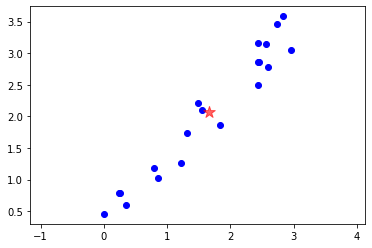

In [2]:
x = 3 * rng.random(20) 
y = x + 0.75* rng.random(20)
fig = plt.figure(); ax = plt.gca()
ax.scatter(x, y, color='b')
ax.scatter(x.mean(), y.mean(),  color='r', marker='*', s=150, alpha=0.6); ax.axis('equal'); 

We put the data in the form of *$m$ samples/observations/rows* for *$n$ variables/features/columns.*

In [3]:
XX = np.array([x, y]).T
m, n = XX.shape

Next, we need to *center the data.* This just means subtracting the mean of each feature/variable. Note that the mean is the marked (as the red star) in above figure.

In [4]:
X = XX - XX.mean(axis=0)

For the visual thinker, centering the data just means moving the origin to the mean (the red star).

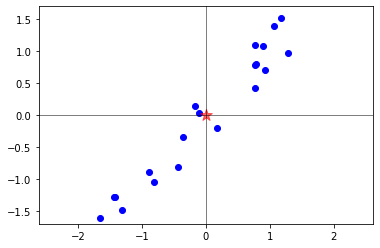

In [5]:
def plotX(X, ax=None):
    if ax is None: fig = plt.figure(); ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], color='b')
    t = np.linspace(-3, 3, 100); o = np.zeros_like(t)
    ax.plot(t, o, 'k', o, t, 'k', linewidth=0.5);
    ax.scatter(0, 0,  color='r', marker='*', s=150, alpha=0.6); 
    ax.axis('equal'); 
    ax.set(xlim=(-1.5,1.5), ylim=(-1.7,1.7));
plotX(X);

Now comes the part that's harder to see, namely the graphical meaning of the maximization problem that defines the first principal component. Consider the figure below where a number of unit vectors are drawn colored.

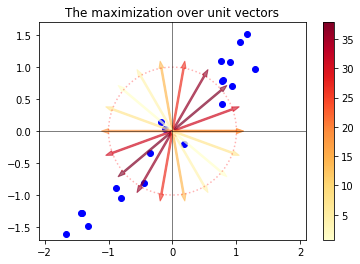

In [8]:
fig = plt.figure(); ax = plt.gca()
ax.set_title('The maximization over unit vectors')
theta = np.linspace(0, 2*np.pi, num=100)     # draw unit circle
ax.plot(np.cos(theta), np.sin(theta), ':r', alpha=0.3)

theta = np.linspace(0, 2*np.pi, num=19)
v = np.array([np.cos(theta), np.sin(theta)]) # unit vectors
f = ((X @ v) ** 2).sum(axis=0)               # function to maximize over v

nrm  = colors.Normalize(vmin=np.min(f), vmax=np.max(f))
sm = cmx.ScalarMappable(norm=nrm, cmap='YlOrRd')
for i in range(v.shape[1]):                  # color vectors based on f value
    ax.arrow(0, 0, v[0, i], v[1, i], width=0.025, color=sm.to_rgba(f[i]), alpha=0.6)
plt.colorbar(sm); plotX(X, ax)

Here, the arrows represent unit vectors $v$, and they are colored according to the value of the following function of the vectors $v$:  
$$
f(v) = \sum_{i=1}^m (v \cdot R_i)^2.
$$
From the figure, there is no doubt that the vectors $v$ for which this function takes the largest values indicate the "dominant" direction of the data points. Once we find the first maximal vector, then we can restrict to the orthogonal complement of that vector and repeat the same maximization to compute further principal components. (In two dimensions, this becomes trivial, so we proceed ignoring further components.)

Statistical literature usually considers the maximization of the function 
$$
g(v) = \frac{1}{m-1}\sum_{i=1}^m (v \cdot R_i)^2
$$
instead of the above $f$. Of course, the maximizers of $f$ and $g$ are the same. The function $g$ represents the *variance* of the data $R_i$ projected onto $v$, which is the statistical quantity that the first principal component maximizes.

How do we solve the maximization problem? The answer is given in the next theorem. 

## PCA and SVD

The key mathematical device for PCA is a tool we have studied in a [prior lecture, the SVD](10_SVD.ipynb).


<span style="color:blue"><b>Theorem 1.</b> 
    Let $X = U \Sigma V^t$ be an SVD of $X \in \mathbb{R}^{m \times n}$ and let $V = [v_1, v_2, \ldots, v_n]$.
    If $X$ represents centered data, then its $i$th
    **principal component** vector 
    equals (up to a sign) the $i$th **right singular vector** $v_i$ of the SVD of $X$.
</span>


For an example, we return to the previous two-dimensional centered dataset `X` and compute its SVD.

In [9]:
u, s, vt = svd(X)

Plotting the first right singular vector as an arrow through the centered data  immediately illustrates the theorem's claim. We find that the first right singular vector is in one of the two directions where we expected the maximizer of $f$, in view of the previous figure. 

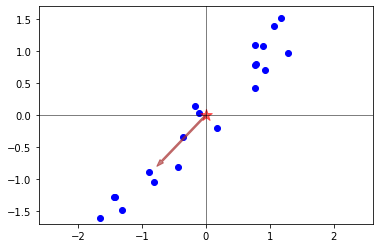

In [10]:
fig = plt.figure(); ax = plt.gca()
ax.arrow(0, 0, vt[0, 0], vt[0, 1], width=0.025, color='brown', alpha=0.6)
plotX(X, ax)

The second singular vector is of course orthogonal to the one shown. (Recall that the columns of a unitary matrix are orthonormal.)

You might now be thinking that this figure is beginning to look like the linear regression figure of the previous lecture, especially if I draw a line through that arrow.  Let me check that thinking right away.  

## PCA is different from regression 

PCA and linear regression are fundamentally different. Note these differences: 

- In supervised learning by regression, the data points were expressed as $(x_i, f_i)$ to indicate that the labels $f_i$ were *dependent* on the data $x_i$.

- In contrast, now the data is viewed as just points on the plane (without any labels) so we express the same points as $(x_i, y_i)$.  We do not start with an  assumption that one data component depends on the other.

- In supervised learning by regression, the task was to predict values of the label $f$ for new values of $x$. In PCA, the task is to discover what relationship exists, if any,  between the $x$ and $y$ values. 

So, in spite of these philosophical differences between linear regression and PCA, why is it producing  similar-looking pictures  in this two-dimensional example?

Actually, the pictures are not quite identical. Let us compute and plot the line obtained with linear regression applied to the same points, now viewing one of the variables (the second) as dependent on the other (the first).

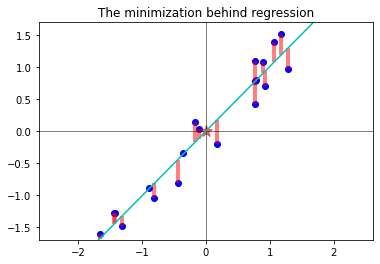

In [11]:
def plot_reg(X, ax):
    x = X[:, 0]; f = X[:, 1] # hypothesizing that f depends on x, perform regression
    X1 = np.array([np.ones(X.shape[0]), x]).T 
    a = np.linalg.inv(X1.T @ X1) @ X1.T @ f
    x_predict = np.linspace(-2, 2, num=100) 
    f_predict = a[0]  + a[1] * x_predict    
    plotX(X, ax)
    ax.plot(x_predict, f_predict, 'c');
    fp = X1 @ a
    lc = LineCollection([[(x[i], f[i]), (x[i], fp[i])] for i in range(len(x))], color='r', linewidth=4, alpha=0.5)
    ax.add_collection(lc)
    ax.set_title('The minimization behind regression');
fig = plt.figure(); ax = plt.gca()
plot_reg(X, ax)

Recall that the line in this linear regression is arrived at by minimizing the sum of the squares of the lengths of the (red) vertical line segments.

In PCA, a different quantity is minimized. Although we defined the principal components using a maximization, we can transform it to a minimization as follows. Recall from linear algebra that any vector can be decomposed into its projection along a given vector and a component in the  orthogonal complement. In particular, for the above two dimensional data,  the vector $R_i$ can be decomposed into its projection along $v$,
$
(v \cdot R_i) v
$
plus the component of $R_i$ in the orthogonal complement of $v$, which using a unit vector $v^\perp$ perpendicular to $v$, may be expressed as
$
(v^\perp \cdot R_i) v^\perp,
$
i.e., 
$$
R_i = (v \cdot R_i)\, v + (v^\perp \cdot R_i)\, v^\perp.
$$
By Pythagoras theorem, 
$$
\| R_i \|^2 =   (v \cdot R_i )^2 + (v^\perp \cdot R_i)^2.
$$
Since the left hand side is fixed by the data, maximizing $(v \cdot R_i )^2$ over all $v$ is equivalent to minimizing $(v^\perp \cdot R_i)^2$ over the perpendicular $v^\perp$.  Thus we arrive at the conclusion that the first principal component $v$ that maximizes
$$
\sum_{i=1}^m (v \cdot R_i)^2
$$
is also the same vector whose $v^\perp$  minimizes 
$$
\sum_{i=1}^m (v^\perp \cdot R_i)^2.
$$
Below is the graphical illustration of this minimization behind the PCA (left plot). We draw little orange line segments from each data point $R_i$ in the direction $v^\perp$ such that its length  equals $ (v^\perp \cdot R_i)^2$. Please  compare it with the previous figure for linear regression, also  reproduced aside below (right plot). 

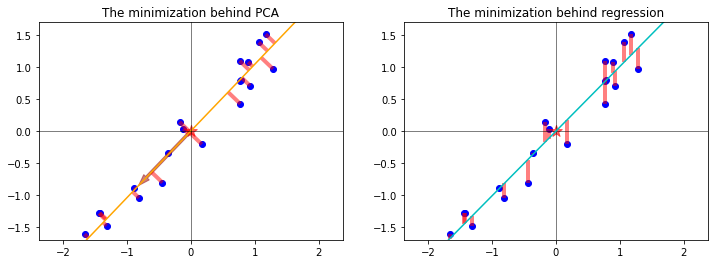

In [13]:
def plot_pca(X, ax):
    u, s, vt = svd(X)
    t = np.linspace(-3, 3, 100); v1 = vt[0, :]
    ax.plot(t*v1[0], t*v1[1], color='orange')
    ax.arrow(0, 0, v1[0], v1[1], width=0.04, color='brown', alpha=0.6)
    Xp = v1[:, np.newaxis] * (X @ v1) 
    lc = LineCollection([[(X[i, 0], X[i, 1]), (Xp[0, i], Xp[1, i])]  for i in range(X.shape[0])], color='r', linewidth=4, alpha=0.5)
    ax.add_collection(lc)
    plotX(X, ax)
    ax.set_title('The minimization behind PCA');
fig = plt.figure(figsize=(12, 4))
axl, axr = fig.subplots(1, 2)
plot_pca(X, axl); plot_reg(X, axr)

Clearly the two minimizations are different. The result of the different minimizations happened to be close for the above example. But this need not happen always. The results can indeed be quite different, as the quick example below shows. 

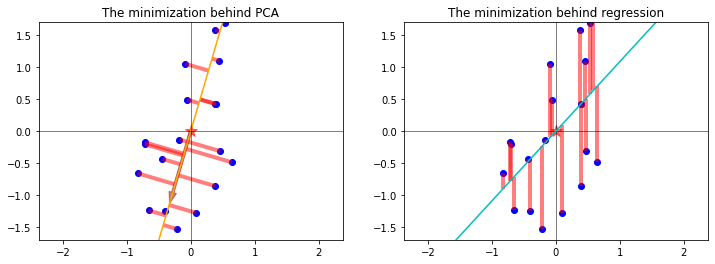

In [14]:
rng = np.random.default_rng(13)
z0 = 1.5 * rng.random(20); z1 = z0 + 2.7 * rng.random(20)
ZZ = np.array([z0, z1 ]).T
Z = ZZ - ZZ.mean(axis=0)
fig = plt.figure(figsize=(12, 4))
axl, axr = fig.subplots(1, 2)
plot_pca(Z, axl); plot_reg(Z, axr)

## PCA in scikit-learn

Instead of getting the principal components from first principles using  the SVD, as we have done above, you may just use scikit-learn's PCA facility to get the same result. 

In [15]:
from sklearn.decomposition import PCA

To use it, one constructs a `PCA` object using some hypothesized `n_components` which can be less than the data dimensions $m$ and $n$. To draw the analogies with the previous computation, let's apply PCA to the previous data setting `n_components=2` (noting that $\min(m, n)=2$ in this example).

In [16]:
pca = PCA(n_components=2)

You can directly give PCA a data set that is not centered. It will do the centering behind the scenes. 

In [17]:
pca.fit(XX);   # fit with raw (uncentered) data

Now, you may ask for the principal components of the data:

In [18]:
pca.components_

array([[-0.69180966, -0.72207991],
       [ 0.72207991, -0.69180966]])

This matches the principal components we computed using the SVD, reproduced below. (Since principal components are defined only up to a sign, the vectors  need only match up to a sign.)

In [19]:
vt

array([[-0.69180966, -0.72207991],
       [ 0.72207991, -0.69180966]])

##  Mapping PCA and SVD jargon

To expand on the above seen relationships, let's consider a larger data set (one that we will examine in more detail in the next section), to bring out the correspondences between what `PCA` provides and what `svd` provides. This will help us understand the concepts from different viewpoints.  

In [20]:
from sklearn.datasets import load_digits
digits = load_digits()
XX = digits.data
X = XX - XX.mean(axis=0)
m, n = XX.shape; m, n

(1797, 64)

The following two lines computes PCA (using scikit-learn) and SVD (using scipy). We will use the resulting outputs to establish correspondences between them so we can be fluent in both languages.

In [21]:
pca = PCA(svd_solver='full').fit(XX)

In [22]:
u, s, vt = svd(X)


#### Correspondences

Now we make a series of observations regarding the outputs from `svd` and `PCA`.

***First,*** the most obvious correspondence is that `pca.singular_values_` and the singular values from scipy's `svd` are the same:

In [23]:
norm(pca.singular_values_ - s)

0.0

***Second,*** the principal components returned by `pca` are equal to $\pm$ ($i$th right singular vector) from the SVD. Let me illustrate this using the above `pca` and `svd` outputs. To check that two vectors are equal except for the sign "$\pm$," we define a function that computes the norms of  the sum and the difference of the vectors and prints them out. Only *one of them* need be zero to have a match up to $\pm$.

In [24]:
def vectors_plus_minus_diff(v1, v2):
    print('%2.1f %2.1f' %(norm(v1 - v2), norm(v1 + v2)))

Using this function we check if the first seven principal components equal the corresponding singular vector up to $\pm$. Note how one of the printed out norms (either that of the sum or that of  the difference) is zero.

In [25]:
for i in range(7):
    vectors_plus_minus_diff(pca.components_[i, :], vt[i, :])    

2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
2.0 0.0
0.0 2.0
0.0 2.0


***Third,*** projections of the original data onto the principal axes can be obtained by `transform` (or the `fit_transform`) method of PCA. They can also be obtained from the SVD $X = U \Sigma V^t$, and the correspondence is as follows:
$$
i^\text{th} \text{column of } \mathtt{pca.fit}\_\mathtt{transform(X)} = \pm\, i^\text{th} \text{column of } U \Sigma.
$$
Here is an illustration of this correspondence for the current example.

In [26]:
# projected data from pca (you can also use pca.fit_transform(XX)):
ftX = pca.transform(XX)

In [27]:
# projected data from svd:
us = u[:, :len(s)] @ np.diag(s)  

In [28]:
# check they are same upto a sign
for i in range(7):
    vectors_plus_minus_diff(ftX[:, i], us[:, i])

1134.0 0.0
1084.5 0.0
1009.3 0.0
852.2 0.0
706.7 0.0
0.0 651.6
0.0 610.5


***Fourth,*** to relate to the low-rank approximation using SVD that we studied in [the SVD lecture](10_SVD.ipynb), recall that an SVD of $X$ can be rewritten using outer products as 
$$
X = \sum_{j=1}^{\min(m, n)} \sigma_j u_j v_j^*
$$
from which the best rank $\ell$ approximation to $X$, denoted by $X_\ell$,  can be extracted simply by throwing away the later summands:
$$
X_\ell = \sum_{j=1}^{\ell} \sigma_j u_j v_j^*.
$$
In scikit-learn, this is accomplished by giving the `n_components` argument, which tells PCA how many principal components to compute.

In [29]:
l = 5   # The rank l approximation needs only l principal components
pcal = PCA(n_components=l, svd_solver='full').fit(XX)

Now, to get the best rank $\ell$ approximation from PCA, we use the `transform` method (which gives $U \Sigma$, per the above discussion), together with the PCA `components_` attribute (which gives $V^t$):

In [30]:
Xl_pca = pcal.transform(XX) @ pcal.components_

The best rank $\ell$ approximation of $X$ is also easy to compute from the SVD:

In [31]:
Xl_svd = u[:, :l] @ np.diag(s[:l]) @ vt[:l, :]

The relative difference in norm between `Xl_pca` and `Xl_svd`  can now be easily verified to be close to machine precision.

In [33]:
norm(Xl_pca - Xl_svd) / norm(Xl_pca)

2.3845543284064683e-15

***Fifth,***  consider the attribute called the `explained_variance` array of the `pca` object. This represents variances explained by the principal components (see the covariance matrix discussion below for more on this terminology). The elements of this array are related to the singular values $\sigma_i$ as follows.
$$
\mathtt{pca.explained}\_\mathtt{variance}\_\mathtt{[i]} = \frac{1}{m-1} \sigma_i^2
$$

In [34]:
norm(pca.explained_variance_ - (s**2/(m-1)))

0.0

***Sixth,***  consider another attribute of the `pca` object called `explained_variance_ratio_`. It is related to singular values as follows: 
$$
\mathtt{pca.explained}\_\mathtt{variance}\_\mathtt{ratio}\_\mathtt{[i]} = \frac{\sigma_i^2}{ \sum_{j} \sigma_j^2}
$$
Obviously, from this, we expect the sum of all the explained variance ratios to be one:

In [35]:
pca.explained_variance_ratio_.sum()

0.9999999999999999

In [37]:
norm(pca.explained_variance_ratio_ - (s**2)/(s**2).sum())

6.661408213830422e-17

#### Covariance matrix

To understand the origin of some of the terms used in `pca` attributes, recall how 
the *covariance matrix* is defined: For centered data, the covariance matrix is 
$$
C = \frac{1}{m-1} X^t X.
$$
The "explained variances" are the eigenvalues of $C$. 
Of course, since $X = U \Sigma V^t$ is an SVD of $X$, the covariance matrix $C$ may be alternately 
expressed as 
$$
C = V \frac{\Sigma^2}{m-1}  V^t,
$$
from which we conclude that the $i$th eigenvalue of $C$ is $\sigma_i^2 / (m-1)$, 
which matches our observation above.

This observation also tells us that the right singular vectors (the columns of $V$) are actually eigenvectors of $C$, since the above factorization of $C$ is actually a diagonalization of $C$. Therefore, one can  alternately compute the right singular vectors, aka, principal components, as the *eigenvectors of the covariance matrix* simply using numpy's or scipy's `eig`. Indeed, for the current example, we can immediately cross check that we get the same results: 

In [38]:
ew, ev = np.linalg.eig(X.T @ X / (m-1)) # eigenvalues & eigenvectors of C
ii = ew.argsort()[::-1]
ew = ew[ii]; ev = ev[:, ii]             # sort by descending order of eigenvalues

In [39]:
norm(ew - s**2 / (m-1))   # eigenvalues equal singular values squared / (m-1)

6.25037049393972e-13

In [40]:
for i in range(7):        # eigenvectors equal +/- principal components
    vectors_plus_minus_diff(pca.components_[i, :], ev[:, i])

2.0 0.0
2.0 0.0
2.0 0.0
0.0 2.0
2.0 0.0
0.0 2.0
0.0 2.0


#### What is better,  `eig` or `svd`? 

The relationship between PCA/SVD and eigenvectors of the  covariance matrix discussed above raises a natural question. If both give the same vectors (principal components), which one should be recommended for computations? 

Even though both give the same vectors mathematically, it's better to use SVD (or scikit-learn's PCA, which uses SVD) to avoid round-off errors in the formation of $X^t X$ that arise in some circumstances. A classical example is the case of a  Läuchli matrix, an $N\times (N-1)$ rectangular matrix of the form 
$$
X = 
\begin{bmatrix}
1        &    1      &  \cdots & 1 \\
\epsilon &           &         & 0 \\
0        & \epsilon  &         & \vdots \\
\vdots   &           & \ddots  \\
\vdots        &           &         & \epsilon \\
0        &           &         & 0
\end{bmatrix} 
$$
with a small number $\epsilon$.
The matrix $X^t X$ then has $1+\epsilon^2$ on the diagonal, and ones everywhere else. This matrix is very close to being singular numerically. For example, in the $N=4$   case,  the matrix
$$
X^t X = 
\begin{bmatrix}
1 + \epsilon^2 &    1           &  1\\
1              & 1 + \epsilon^2 &  1 \\
1              &    1            & 1 + \epsilon^2
\end{bmatrix} 
$$
has eigenvalues  $3+ \epsilon^2, \epsilon^2, \epsilon^2$ by hand calculation. However, `eig` is unable to distinguish the latter from zero. 

In [51]:
N = 4
eps = 1e-8
X = np.diag(eps * np.ones(N), k=-1)
X[0, :] = 1;  X = X[:, :(N-1)]; X

array([[1.e+00, 1.e+00, 1.e+00],
       [1.e-08, 0.e+00, 0.e+00],
       [0.e+00, 1.e-08, 0.e+00],
       [0.e+00, 0.e+00, 1.e-08],
       [0.e+00, 0.e+00, 0.e+00]])

In [52]:
ew, ev = np.linalg.eig(X.T @ X)
ii = ew.argsort()[::-1]; ev = ev[:, ii]; ew = ew[ii]
ew

array([ 3.00000000e+00,  0.00000000e+00, -2.22044605e-16])

Now, we may attempt to compute the singular values by taking square roots of these eigenvalues.

In [53]:
np.sqrt(ew)

<ipython-input-53-6f1372a76c3a>:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(ew)


array([1.73205081, 0.        ,        nan])

In contrast, the SVD is able to output the singular values fairly close to the exact ones
$\sqrt{3+ \epsilon^2}, \epsilon, \epsilon$ without difficulty.

In [44]:
u, s, vt = svd(X)
s

array([1.73205081e+00, 1.00000000e-08, 5.77350269e-09])

## Hand-written digits dataset

Scikit-learn comes with an example dataset representing many images of hand-written digits for use as a test problem in optical character recognition. Actually, this  is the same `digits` data we have been working with above. Let's take a closer look at this  dataset.

In [54]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

We used `digits.data` previously. The `images` key gives the images of the handwritten digits. 

In [55]:
digits.images.shape, digits.data.shape

((1797, 8, 8), (1797, 64))

There are 1797 images, each of 8 x 8 pixels. The flattened array versions of these images are in `digits.data` while the $8 \times 8$ image versions are in `digits.images`. Here are the first few of the 1797 images:

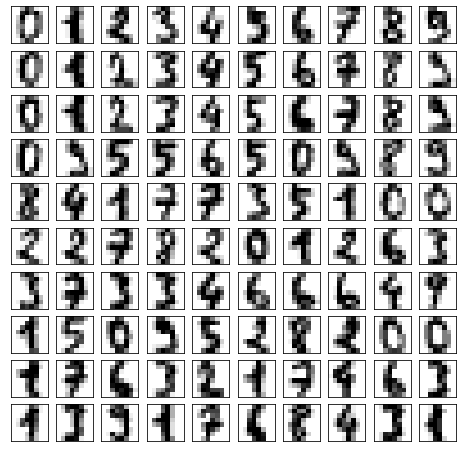

In [56]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary')

To apply PCA, we need to put these images into the tidy data format of 
$m$  samples/observations/rows $ \times$ $n$  variables/features/columns. We set 
- each *pixel* to be a *feature*/variable, 
- each *image* to be a *sample*/observation.

Actually, this is the form the data is contained in `digits.data`, where  each $8 \times 8$ image is one of 1797 samples of a 64-variable dataset.

In [57]:
m, n = digits.data.shape
m, n 

(1797, 64)

We construct a `PCA` object using this data asking specifically to retain only $10$ principal components.

In [58]:
pca = PCA(n_components=10).fit(digits.data)

Would you hazard a guess that the 10 principal components are the usual 10 digits?

Well $\ldots$. Here is how  the 10 principal components look like: 

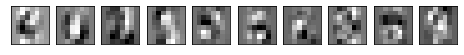

In [59]:
fig, axes = plt.subplots(1, 10, figsize=(8, 4), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i, :].reshape(8, 8), cmap='binary')

Obviously, they don't look anything like recognizable digits.  It is important to understand in what sense these garbled images represent something "principal" about the original data set. Proceed on to gain this understanding.

## PCA is a feature finder

To make sense of the above garbled images as a basis, let's use the `transform` method (which computes $U \Sigma$).  

In [60]:
dgt = pca.transform(digits.data)
dgt.shape

(1797, 10)

Each row of `dgt` contains 10 coefficients, which when multiplied by the 10 principal components, reveal what's going on. Of course, we must also correct for the previously subtracted mean. The first row of `dgt` then yields the following image (left). Compare it with the original first image in the data (right).

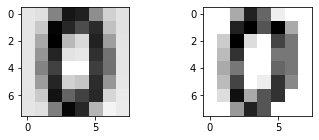

In [61]:
fig = plt.figure(figsize=(6, 2))
axl, axr = fig.subplots(1, 2)
im0 = dgt[0, :] @ pca.components_ + pca.mean_
axl.imshow(im0.reshape(8, 8), cmap='binary')
axr.imshow(digits.images[0], cmap='binary');

Let's dig a bit more into this. Writing the SVD of the centered image data array `X` as
$$
X = \sum_k \sigma_k u_k v_k^t,
$$
we may read off the the $i$th row $R_i$, which represents the $i$th image in this dataset, as follows:
$$
[R_i]_j = X_{ij} = \sum_k \sigma_k [u_k]_i [v_k]_j.
$$
The `pca` object above computed the rank-10 best approximation by restricting the above sum to the first 10 summands. This is what was implemented by the  line of code that generated the left image above,  
```py
im0 = dgt[0, :] @ pca.components_ + pca.mean_
```
which further restricted to the first image, the $i=0$ case, and also corrected for the mean (since PCA performs SVD  on centered data).

It is instructive to view the  above formula for the $i$th image/row $R_i$ as the sum 

$$
f(x) = a_0 \phi_0(x) + a_1 \phi_1(x) + \cdots a_{9} \phi_{9}(x)
$$

where the numbers $a_k = [\sigma_k u_k]_i$ represent coefficients in a basis expansion with the *basis images* $\phi_k$ set by $\phi_k = v_k$, and where $x$ represents one of the 64 pixels. In this viewpoint, what PCA has done is to fit the 10-term formula to a data set of 1797 images. While this is reminiscent of regression, note  two important differences:

- PCA found the basis $\phi_k$ (while regression needs $\phi_k$ as input).
- The coefficients $a_k$ change for each data row (unlike in regression where it's fixed for the whole dataset).

To summarize,  *PCA automatically finds features/basis to represent datasets* (while regression needs you to provide a basis - see e.g., the curve fitting examples we have seen previously). This exemplifies one of the differences between supervised and unsupervised learning.

## PCA is useful for dimensionality reduction 

Looking back to the left (PCA) and right (original data)  images in the previous figure, the following interpretation is hard to miss:  the original 64-dimensional dataset might actually be well represented in a 10-dimensional space. 

The number 10 was, of course, arbitrary, and somewhat of a red herring in a dataset of images of 10 digits. It would be better if the data itself can lead us to some number of relevant dimensions it possesses. This is where the `explained_variance_ratio` becomes useful. Let's return to the full PCA and examine this array. Recall that it is an array that sums to one, so its *cumulative sums* indicate how close we are to fully representing the data.

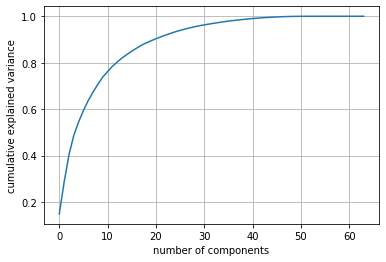

In [62]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Clearly, with 10 components, we are far away from the cumulative sum of 1. We are much closer to the point of diminishing returns, retaining about 95% of the variance, if we instead choose,  say 30 components. 

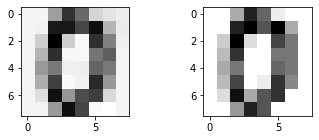

In [63]:
pca = PCA(n_components=30).fit(digits.data)
dgt = pca.fit_transform(digits.data)
fig = plt.figure(figsize=(6, 2))
axl, axr = fig.subplots(1, 2)
im0 = dgt[0, :] @ pca.components_ + pca.mean_
axl.imshow(im0.reshape(8, 8), cmap='binary')
axr.imshow(digits.images[0], cmap='binary');

In other words, the 64-dimensional data set may effectively be reduced to a 30-dimensional dataset retaining 95% of the information. (Per our discussion in SVD, you can, of course, convert this statement into a measure of relative error in the Frobenius norm.)  Summarizing, PCA is also useful as a dimensionality reduction tool.



<hr>




<span style="color:rgb(106,127,16); font-size:8pt">These materials were created by</span> [<span style="color:rgb(106,127,16); font-size:8pt">Jay Gopalakrishnan</span>](http://web.pdx.edu/~gjay/) <span style="color:rgb(106,127,16); font-size:8pt">for a sophomore course (MTH 271) offered during the Spring 2020 quarter at Portland State University, and are made available under the</span> [<span style="color:rgb(106,127,16) ; font-size:8pt">CC-BY-SA license</span>](https://creativecommons.org/licenses/by-sa/4.0/legalcode).
 








